In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt

# Introduction to Tethne: Words and Topic Modeling

In this workbook we'll start working with word-based ``FeatureSet``s, and use the ``model.corpus.mallet`` module to  fit a [Latent Dirichlet Allocation](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA) topic model.

## Before you start

* Download the practice dataset from [here](http://devo-evo.lab.asu.edu/methods/tethne/datasets.zip), and store it in a place where you can find it. You'll need the full path to your dataset.


## Loading JSTOR DfR datasets

First, import the ``dfr`` module from ``tethne.readers``.

In [3]:
from tethne.readers import dfr

Unlike WoS datasets, DfR datasets can contain wordcounts, bigrams, trigrams, and quadgrams in addition to bibliographic data. ``read`` will automagically load those data as ``FeatureSet``s. 

In [4]:
corpus = dfr.read('/Users/erickpeirson/Projects/tethne-notebooks/data/dfr')

In [5]:
print 'There are %i papers in this corpus.' % len(corpus.papers)

There are 241 papers in this corpus.


In [6]:
print 'This corpus contains the following features: \n\t%s' % '\n\t'.join(corpus.features.keys())

This corpus contains the following features: 
	citations
	wordcounts
	authors


In [19]:
p = corpus[15]

In [21]:
from tethne.networks.authors import coauthors

In [22]:
graph = coauthors(corpus)

In [28]:
from tethne.writers.graph import to_graphml

In [29]:
to_graphml(graph, '/Users/erickpeirson/Desktop/coauthors.graphml')

Whereas Corpora generated from WoS datasets are indexed by ``wosid``, Corpora generated from DfR datasets are indexed by ``doi``.

In [7]:
corpus.indexed_papers.keys()[0:10]    # The first 10 dois in the Paper index.

['10.2307/2418718',
 '10.2307/2258178',
 '10.2307/3241549',
 '10.2307/2416998',
 '10.2307/20000814',
 '10.2307/2428935',
 '10.2307/2418714',
 '10.2307/1729159',
 '10.2307/2407516',
 '10.2307/2816048']

So you can retrieve specific ``Paper``s from ``Corpus.papers`` using their DOIs:

In [8]:
corpus['10.2307/2418718']

## Working with featuresets

``FeatureSet``s are stored in the ``features`` attribute of a ``Corpus`` object. ``Corpus.features`` is just a dict, so you can see which featuresets are available by calling its ``keys`` method.

In [30]:
print 'This corpus contains the following featuresets: \n\t{0}'.format(
            '\n\t'.join(corpus.features.keys())    )

This corpus contains the following featuresets: 
	citations
	wordcounts
	authors


It's not uncommon for featuresets to be incomplete; sometimes data won't be available for all of the Papers in the Corpus. An easy way to check the number of Papers for which data is available in a ``FeatureSet`` is to get the size (``len``) of the ``features`` attribute of the ``FeatureSet``. For example:

In [31]:
print 'There are %i papers with unigram features in this corpus.' % len(corpus.features['wordcounts'].features)

There are 241 papers with unigram features in this corpus.


To check the number of features in a featureset (e.g. the size of a vocabulary), look at the size of the ``index`` attribute.

In [32]:
print 'There are %i words in the unigrams featureset' % len(corpus.features['wordcounts'].index)

There are 52207 words in the unigrams featureset


``index`` maps words to an integer representation. Here are the first ten words in the ``FeatureSet``:

In [33]:
corpus.features['wordcounts'].index.items()[0:10]

[(0, 'dynamic'),
 (1, 'relationships'),
 (2, 'calculate'),
 (3, 'physiological'),
 (4, 'segments'),
 (5, 'under'),
 (6, 'emlen'),
 (7, 'worth'),
 (8, 'experimentally'),
 (9, 'alpine')]

### Applying a stoplist

In many cases you may wish to apply a stoplist (a list of features to exclude from analysis) to a featureset. In our DfR dataset, the most common words are prepositions and other terms that don't really have anything to do with the topical content of the corpus.

In [34]:
corpus.features['wordcounts'].top(5)    # The top 5 words in the FeatureSet.

[('the', 74619.0),
 ('of', 67372.0),
 ('and', 42712.0),
 ('in', 36453.0),
 ('a', 22590.0)]

You may apply any stoplist you like to a featureset. In this example, we import the [Natural Language ToolKit (NLTK)](http://www.nltk.org/) stopwords corpus.

In [35]:
from nltk.corpus import stopwords
stoplist = stopwords.words()

We then create a function that will evaluate whether or not a word is in our stoplist. The function should take three arguments:

* ``f`` -- the feature itself (the word)
* ``v`` -- the number of instances of that feature in a specific document
* ``c`` -- the number of instances of that feature in the whole FeatureSet
* ``dc`` -- the number of documents that contain that feature

This function will be applied to each word in each document. If it returns ``0`` or ``None``, the word will be excluded. Otherwise, it should return a numeric value (in this case, the count for that document).

In addition to applying the stoplist, we'll also exclude any word that occurs in more than 50 of the documents and less than 3 documents.

In [36]:
def apply_stoplist(f, v, c, dc):
    if f in stoplist or dc > 50 or dc < 3:
        return 0
    return v

We apply the stoplist using the ``transform()`` method. ``FeatureSet``s are not modified in place; instead, a new ``FeatureSet`` is generated that reflects the specified changes. We'll call the new ``FeatureSet`` ``'wordcounts_filtered'``.

In [37]:
corpus.features['wordcounts_filtered'] = corpus.features['wordcounts'].transform(apply_stoplist)

In [38]:
print 'There are %i words in the wordcounts_filtered FeatureSet' % len(corpus.features['wordcounts_filtered'].index)

There are 12204 words in the wordcounts_filtered FeatureSet


## Topic modeling with featuresets

[Latent Dirichlet Allocation](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) is a popular approach to discovering latent "topics" in large corpora. Many digital humanists use a software package called [MALLET](http://mallet.cs.umass.edu/) to fit LDA to text data. Tethne uses MALLET to fit LDA topic models.

Start by importing the ``mallet`` module from the ``tethne.model.corpus`` subpackage.

In [39]:
from tethne.model.corpus import mallet

Now we'll create a new ``LDAModel`` for our ``Corpus``. The ``featureset_name`` parameter tells the ``LDAModel`` which ``FeatureSet`` we want to use. We'll use our filtered wordcounts.

In [40]:
model = mallet.LDAModel(corpus, featureset_name='wordcounts_filtered')

Next we'll fit the model. We need to tell MALLET how many topics to fit (the hyperparameter ``Z``), and how many iterations (``max_iter``) to perform. This step may take a little while, depending on the size of your corpus.

In [41]:
model.fit(Z=50, max_iter=500)

You can inspect the inferred topics using the model's ``print_topics()`` method. By default, this will print the top ten words for each topic.

In [42]:
model.print_topics()

Topic	Top 10 words
0  	productivity ecosystem food conservation management ecosystems ibp nutrient balance resource
1  	relict ancient relicts lakes dealing places localities fauna marine copenhagen
2  	fairly commonly partial differentiated abundant remain represents considerably condition criteria
3  	zealand herbarium varieties compound impossible referred refer definite bearing taxonomist
4  	cultivated darwin domestic genes constitution crossing changed caused domestication polyploidy
5  	ssp wheat nepal fitness subspecies pond barley drummondii pakistan loci
6  	gunnera fossil usa insignis colonies cretaceous polar studying africa palynology
7  	rain islands island forests tropics spores speciation fern ferns forester
8  	william david richard james george charles paul thomas joseph donald
9  	seq fen dunes upland rain bog grazing succession weed dune
10 	illus edition pages chapter chemistry chapters comprehensive elementary presents textbook
11 	pollination floral insects insec

We can also look at the representation of a topic over time using the ``topic_over_time()`` method. In the example below we'll print the first five of the topics on the same plot.

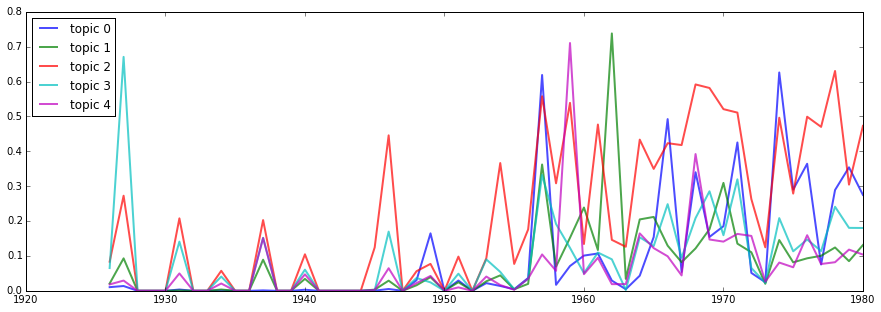

In [43]:
plt.figure(figsize=(15, 5))
for k in xrange(5):
    x, y = model.topic_over_time(k)
    plt.plot(x, y, label='topic {0}'.format(k), lw=2, alpha=0.7)
plt.legend(loc='best')
plt.show()    

## Generating networks from topic models

The ``features`` module in the ``tethne.networks`` subpackage contains some useful methods for visualizing topic models as networks. You can import it just like the ``authors`` or ``papers`` modules.

In [44]:
from tethne.networks import topics

In [45]:
termGraph = topics.terms(model, threshold=0.01)

In [46]:
termGraph.name = ''

The ``topic_coupling`` function generates a network of words connected on the basis of shared affinity with a topic. If two words *i* and *j* are both associated with a topic *z* with $\Phi(i|z) >= 0.01$ and $\Phi(j|z) >= 0.01$, then an edge is drawn between them. 

The resulting graph will be smaller or larger depending on the value that you choose for ``threshold``. You may wish to increase or decrease ``threshold`` to achieve something interpretable.

In [47]:
print 'There are {0} nodes and {1} edges in this graph.'.format(
            len(termGraph.nodes()), len(termGraph.edges()))

There are 486 nodes and 3362 edges in this graph.


The resulting ``Graph`` can be written to ``GraphML`` just like any other ``Graph``.

In [48]:
from tethne.writers import graph

In [49]:
graphpath = '/Users/erickpeirson/Projects/tethne-notebooks/output/lda.graphml'
graph.write_graphml(termGraph, graphpath)

The network visualization below was generated in ``Cytoscape``. Edge width is a function of the ``'weight'`` attribute. Edge color is based on the ``'topics'`` attribute, to give some sense of how which clusters of terms belong to which topics. We can see right away that terms like ``plants``, ``populations``, ``species``, and ``selection`` are all very central to the topics retrieved by this model.

![](images/lda2.png)

## WoS abstracts

JSTOR DfR is not the only source of wordcounts with which we perform topic modeling. For records more recent than about 1990, the Web of Science includes abstracts in their bibliographic records.

Let's first spin up our WoS dataset.

In [50]:
from tethne.readers import wos
wosCorpus = wos.read('/Users/erickpeirson/Projects/tethne-notebooks/data/wos')

Here's what one of the abstracts looks like:

In [51]:
wosCorpus[0].abstract

u'Demographic models are powerful tools for making predictions about the relative importance of transitions from one life stage (e. g., seeds) to another (e. g., nonreproductives); however, they have never been used to compare the relative performance of invasive and noninvasive taxa. I use demographic models parameterized from common garden experiments to develop hypotheses about the role of different life stage transitions in determining differences in performance in invasive and noninvasive congeners in the Commelinaceae. I also extended nested life table response experiment (LTRE) analyses to accommodate interactions between nested and unnested factors. Invasive species outperformed their noninvasive congeners, especially under high-nutrient conditions. This difference in performance did not appear to be due to differences in elasticities of vital rates, but rather to differences in the magnitude of stage transitions. Self-compatible invasive species had greater fecundity in high-n

The ``abstract_to_features`` method converts all of the available abstracts in our ``Corpus`` to a unigram featureset. It takes no arguments. The abstracts will be diced up into their constituent words, punctuation and capitalization is removed, and a featureset called ``abstractTerms`` is generated. By default, ``abstract_to_features`` will apply the NLTK stoplist and Porter stemmer.

In [52]:
from tethne import tokenize
wosCorpus.index_feature('abstract', tokenize=tokenize, structured=True)

Sure enough, here's our ``'abstract'`` featureset:

In [53]:
wosCorpus.features.keys()

['abstract', 'citations', 'authors']

Since we're not working from OCR texts (that's where JSTOR DfR data comes from), there are far fewer "junk" words. We end up with a much smaller vocabulary.

In [54]:
print 'There are {0} features in the abstract featureset.'.format(len(wosCorpus.features['abstract'].index))

There are 23732 features in the abstract featureset.


But since not all of our WoS records come from >= 1990, there are a handful for which there are no abstract terms.

In [56]:
print 'Only {0} of {1} papers have abstracts, however.'.format(len(wosCorpus.features['abstract'].features), len(wosCorpus.papers))

Only 1778 of 1859 papers have abstracts, however.


In [57]:
filter = lambda f, v, c, dc: f not in stoplist and 2 < dc < 400
wosCorpus.features['abstract_filtered'] = wosCorpus.features['abstract'].transform(filter)

In [58]:
print 'There are {0} features in the abstract_filtered featureset.'.format(len(wosCorpus.features['abstract_filtered'].index))

There are 23732 features in the abstract_filtered featureset.


In [59]:
type(wosCorpus.features['abstract_filtered'])

tethne.classes.feature.StructuredFeatureSet

The ``'abstract'`` featureset is similar to the ``'unigrams'`` featureset from the JSTOR DfR dataset, so we can perform topic modeling with it, too.

In [60]:
wosModel = mallet.LDAModel(wosCorpus, featureset_name='abstract_filtered')

In [61]:
wosModel.fit(Z=50, max_iter=500)

In [62]:
wosModel.print_topics(Nwords=5)

Topic	Top 10 words
0  	usa biol dept univ common
1  	resistance tolerance dept usa genotypes
2  	fish wild marine age differences
3  	stress inst studies switzerland experiments
4  	seedlings survival seedling weight conditions
5  	water drought efficiency photosynthetic lower
6  	competition clones interaction effect study
7  	univ germany inst chile ecotypes
8  	predation predator presence differences risk
9  	seed seeds germination production garden
10 	flowering early season phenology time
11 	variation genetic patterns geographic pattern
12 	native invasive range introduced plants
13 	traits plant biomass root density
14 	temperature degrees temperatures northern southern
15 	differences sites site significant morphological
16 	high low mexico elevation common
17 	finland females males biol univ
18 	plant plants herbivores herbivory damage
19 	plant univ pollen floral flower
20 	hybrid hybrids fitness wild taxa
21 	analysis data variables model revealed
22 	traits selection evolut

``topics.cotopics()`` creates a network of topics, linked by virtue of their co-occurrence in documents. Use the ``threshold`` parameter to tune the density of the graph.

In [63]:
coTopicGraph = topics.cotopics(wosModel, threshold=0.15)

In [64]:
print '%i nodes and %i edges' % (coTopicGraph.order(), coTopicGraph.size())

44 nodes and 90 edges


In [65]:
graph.write_graphml(coTopicGraph, '/Users/erickpeirson/Projects/tethne-notebooks/output/lda_coTopics.graphml')

![](images/lda_coTopics.png)

``topics.topicCoupling()`` creates a network of documents, linked by virtue of containing shared topics. Again, use the ``threshold`` parameter to tune the density of the graph.

In [66]:
topicCoupling = topics.topic_coupling(wosModel, threshold=0.2)

In [67]:
print '%i nodes and %i edges' % (topicCoupling.order(), topicCoupling.size())

742 nodes and 8311 edges


In [68]:
graph.write_graphml(topicCoupling, '/Users/erickpeirson/Projects/tethne-notebooks/output/lda_topicCoupling.graphml')

![](images/lda_topicCoupling.png)

In [71]:
wosCorpus.features['abstract_filtered'].features.values()[0]

[u'demographic',
 u'models',
 u'are',
 u'powerful',
 u'tools',
 u'for',
 u'making',
 u'predictions',
 u'about',
 u'the',
 u'relative',
 u'importance',
 u'of',
 u'transitions',
 u'from',
 u'one',
 u'life',
 u'stage',
 u'e',
 u'g',
 u'seeds',
 u'to',
 u'another',
 u'e',
 u'g',
 u'nonreproductives',
 u'however',
 u'they',
 u'have',
 u'never',
 u'been',
 u'used',
 u'to',
 u'compare',
 u'the',
 u'relative',
 u'performance',
 u'of',
 u'invasive',
 u'and',
 u'noninvasive',
 u'taxa',
 u'i',
 u'use',
 u'demographic',
 u'models',
 u'parameterized',
 u'from',
 u'common',
 u'garden',
 u'experiments',
 u'to',
 u'develop',
 u'hypotheses',
 u'about',
 u'the',
 u'role',
 u'of',
 u'different',
 u'life',
 u'stage',
 u'transitions',
 u'in',
 u'determining',
 u'differences',
 u'in',
 u'performance',
 u'in',
 u'invasive',
 u'and',
 u'noninvasive',
 u'congeners',
 u'in',
 u'the',
 u'commelinaceae',
 u'i',
 u'also',
 u'extended',
 u'nested',
 u'life',
 u'table',
 u'response',
 u'experiment',
 u'ltre',
 u'ana